<h1>Testing the calibration</h1>

After we have confirmed what our E2E simulation images from WebbPSF look like, let's test the calibration script "calibration.py".

In [1]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

os.chdir('../python/')
from config import CONFIG_INI

# Path to all the outputs from "aperture_definition.py".
dir = '/Users/ilaginja/Documents/data_from_repos/pastis_data/calibration'
# Change into that directory
os.chdir(dir)

In [2]:
# Set up limits for zooming into images
im_size = CONFIG_INI.getint('numerical', 'im_size_px')          # image size in pixels
sampling = CONFIG_INI.getfloat('numerical', 'sampling')         # sampling
outer_wa = CONFIG_INI.getint('coronagraph', 'OWA')              # outer working angle of coronagraph
up = im_size/2 + sampling*(outer_wa+3)
down = im_size/2 - sampling*(outer_wa+3)

Let's first check the direct and coronagraphic PSF from the E2E simulation.

(1024, 1024)
(1024, 1024)


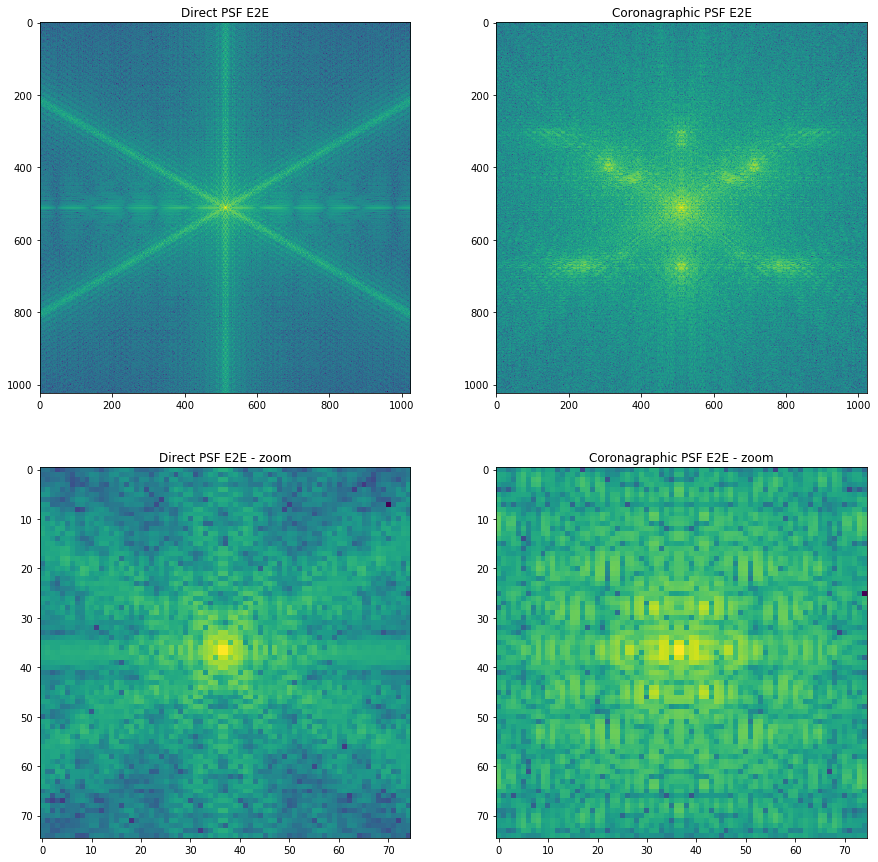

In [3]:
psf_direct = fits.getdata('psf_default.fits')
psf_coro = fits.getdata('psf_coro.fits')
print(psf_direct.shape)
print(psf_coro.shape)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(psf_direct, norm=LogNorm())
plt.title('Direct PSF E2E')

plt.subplot(2, 2, 2)
plt.imshow(psf_coro, norm=LogNorm())
plt.title('Coronagraphic PSF E2E')

plt.subplot(2, 2, 3)
plt.imshow(psf_direct[475:550, 475:550], norm=LogNorm())
plt.title('Direct PSF E2E - zoom')

plt.subplot(2, 2, 4)
plt.imshow(psf_coro[475:550, 475:550], norm=LogNorm())
plt.title('Coronagraphic PSF E2E - zoom')

plt.show()

Load the dark hole and see what it looks like by itseld and when overlapped with the two images.

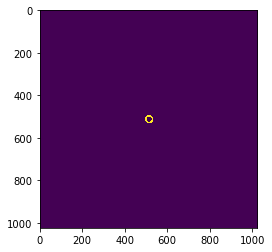

In [4]:
dh = fits.getdata('dh_area.fits')
plt.imshow(dh)
plt.show()

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  del sys.path[0]
/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


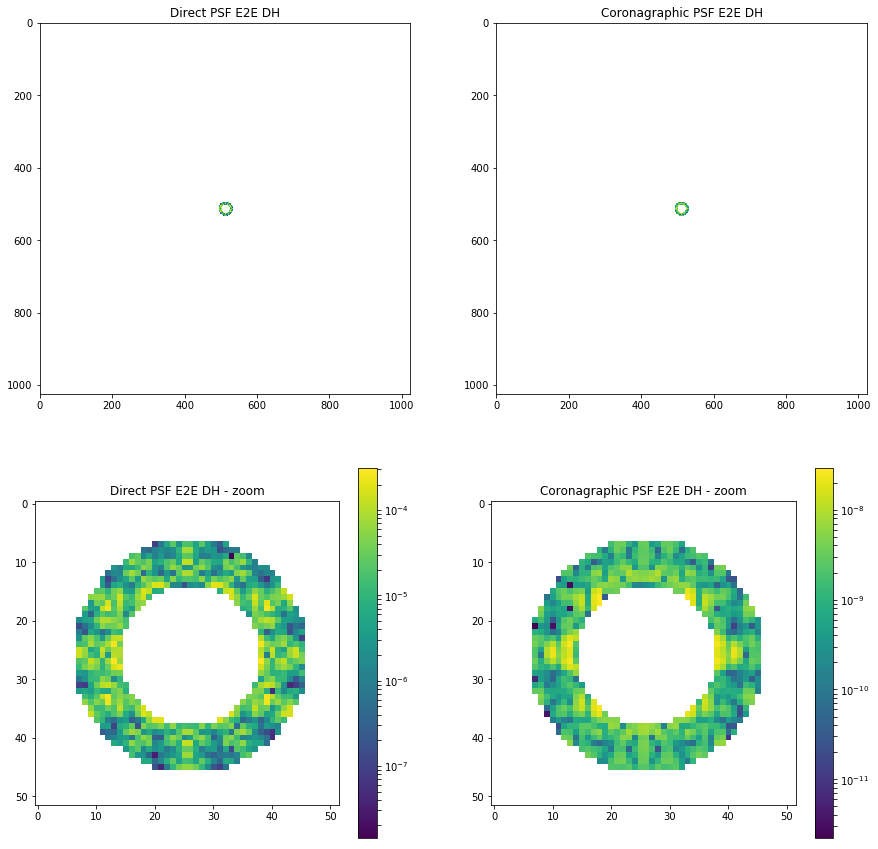

In [5]:
# DH over PSFs (dh over direct PSF is a useles concept, but I wanted to see what it looks like).

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(psf_direct*dh, norm=LogNorm())
plt.title('Direct PSF E2E DH')

plt.subplot(2, 2, 2)
plt.imshow(psf_coro*dh, norm=LogNorm())
plt.title('Coronagraphic PSF E2E DH')

plt.subplot(2, 2, 3)
plt.imshow((psf_direct*dh)[down:up, down:up], norm=LogNorm())
plt.title('Direct PSF E2E DH - zoom')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow((psf_coro*dh)[down:up, down:up], norm=LogNorm())
plt.title('Coronagraphic PSF E2E DH - zoom')
plt.colorbar()

plt.show()

Read in the baseline contrast to see what it is. You will have to adjust the file name.

In [6]:
blcontr = np.loadtxt('base-contrast_piston_Noll1.txt')
print('Baseline contrast E2E simulation:', blcontr)

Baseline contrast E2E simulation: 2.3115426700097535e-08
